<a href="https://colab.research.google.com/github/lhw0772/deepstock/blob/master/simple_lstm_kospi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. yahoo 데이터 가져오기

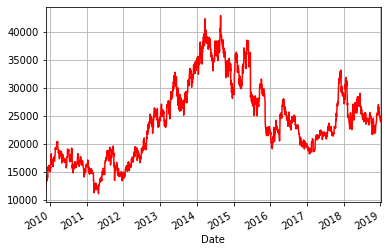

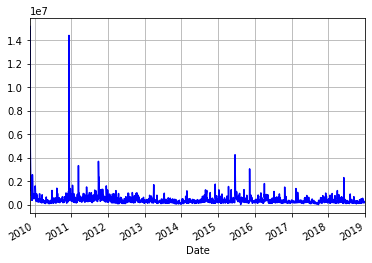

In [0]:
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing 

some_company = pdr.get_data_yahoo('114090.KS', 
                          start=datetime.datetime(2002, 1, 1), 
                          end=datetime.datetime(2019, 1,1))

#print (some_company.index)
#print (some_company.columns)

import matplotlib.pyplot as plt 

# Plot the closing prices for `some_company`

#some_company['Adj Close'].plot(grid=True,color = 'red')
#some_company=some_company['Adj Close'].to_numpy()

# Show the plot
#plt.show()

def get_stock_hist(code,start,end):
  info = pdr.get_data_yahoo('114090.KS', 
                          start=start, 
                          end=end)
  return info

code = '114090.KS'
start = datetime.datetime(2002, 1, 1)
end = datetime.datetime(2019, 1,1)
hist=get_stock_hist(code,start,end)

def display_hist(hist):
  hist['Adj Close'].plot(grid=True,color = 'red')
  plt.show()
  hist['Volume'].plot(grid=True,color = 'blue')
  plt.show()

display_hist(hist)


2. 코스피 800 종목 리스트 불러오기

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import io

kospi_list = pd.read_csv('/content/gdrive/My Drive/kospi/data.csv',error_bad_lines=False)['종목코드']
print (kospi_list)

0      095570
1      006840
2      027410
3      282330
4      138930
        ...  
798    079980
799    005010
800    069260
801    000540
802    003280
Name: 종목코드, Length: 803, dtype: object


b'Skipping line 442: expected 12 fields, saw 13\n'


In [0]:
from sklearn import preprocessing 
def save_preproc_kospi(_start,_end,_period,_filename):
  start = _start
  end = _end
  period = _period
  min_max_scaler = preprocessing.MinMaxScaler()

  train_x =[]
  train_y =[]

  valid_x =[]
  valid_y =[]

  test_x =[]
  test_y =[]

  code_cnt = 0
  total_code_num = len(kospi_list)

  for code in kospi_list:
    print (str(code_cnt)+"/"+str(total_code_num))
    code_cnt +=1 
    if(code.isdigit() == True):
      hist=get_stock_hist(code,start,end)

      total_len=len(hist)
      start_idx =0
      end_idx =start_idx+period+1

      while end_idx < total_len:
        split_data=hist[start_idx:end_idx] ## start_idx ~ end_idx  # 0~30 
        feature = split_data.iloc[:,4:6]
        scaled_feature = min_max_scaler.fit_transform(feature)
        label = scaled_feature[30][1] - scaled_feature[29][1]

        if(label >0):
          label = 1
        else:
          label = 0

        start_idx +=1
        end_idx +=1

        train_x.append(scaled_feature[:-1])
        train_y.append(label)

  train_x = np.array(train_x)
  train_y = np.array(train_y)

  print (train_x.shape)
  print (train_y.shape)

  np.save(_filename+"_x",train_x)
  np.save(_filename+"_y",train_y)
  print ('save')


  

    

In [0]:
print ('training data loading')
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 1,1)
period = 60
save_preproc_kospi(start,end,period,'/content/gdrive/My Drive/kospi/train_60')

print ('testing data loading')
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1,1)
period = 60
save_preproc_kospi(start,end,period,'/content/gdrive/My Drive/kospi/test_60')


In [0]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
from keras import backend as K

def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import to_categorical
import os
from keras.callbacks import ModelCheckpoint
import numpy as np


def create_model():
  model = Sequential()

  model.add(LSTM(units=50, return_sequences=True,input_shape=(60,2)))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50))
  model.add(Dropout(0.2))

  model.add(Dense(units = 2,activation='softmax'))

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
  metrics=['accuracy',single_class_precision(0), single_class_recall(0),
                       single_class_precision(1), single_class_recall(1)])

  return model

kospi_train_x = np.load('/content/gdrive/My Drive/kospi/train_60_x.npy')
kospi_train_y = np.load('/content/gdrive/My Drive/kospi/train_60_y.npy')

kospi_test_x = np.load('/content/gdrive/My Drive/kospi/test_60_x.npy')
kospi_test_y = np.load('/content/gdrive/My Drive/kospi/test_60_y.npy')

kospi_train_y=to_categorical(kospi_train_y)
kospi_test_y=to_categorical(kospi_test_y)
print (kospi_train_x.shape) 
print (kospi_train_y.shape)


model = create_model()

checkpoint_path = "/content/gdrive/My Drive/kospi/model_60-{epoch:04d}.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    period=1)

model.save_weights(checkpoint_path.format(epoch=0))

hist = model.fit(kospi_train_x,kospi_train_y,batch_size=64, epochs=100,validation_data=
          (kospi_test_x,kospi_test_y),callbacks = [cp_callback])


(732800, 60, 2)
(732800, 2)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 732800 samples, validate on 87543 samples
Epoch 1/100
732800/732800 [==============================] - 2107s 3ms/step - loss: 0.4580 - acc: 0.7496 - prec: 0.7511 - recall: 0.8002 - prec_1: 0.7461 - recall_1: 0.6926 - val_loss: 1.8778 - val_acc: 0.5049 - val_prec: 0.5361 - val_recall: 0.3722 - val_prec_1: 0.4719 - val_recall_1: 0.6439

Epoch 00001: saving model to /content/gdrive/My Drive/kospi/model_60-0001.h5
Epoch 2/100
732800/732800 [==============================] - 2115s 3ms/step - loss: 0.3823 - acc: 0.8033 - prec: 0.8098 - recall: 0.8243 - prec_1: 0.7964 - recall_1: 0.7798 - val_loss: 1.6837 - val_acc: 0.4625 - val_prec: 0.4985 - val_recall: 0.4879 - val_prec_1: 0.4113 - val_recall_1: 0.4237

Epoch 00002: saving model to /c